In [1]:
from functools import partial
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz
from astropy.cosmology import LambdaCDM
import pandas as pd
from schwimmbad import MultiPool
from uncertainties import unumpy
from scipy import integrate

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000, GrainsWD01
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
)
from synthesizer.conversions import lnu_to_absolute_mag

np.random.seed(680010)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from lmfit import Model

from utilities import calc_line_corr, calc_line_corr_from_Av, get_flares_LF

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)
plt.style.use('styles/style.mplstyle')

In [2]:
def Ha_to_SFR(Ha):
    
    sfr = 10**(-41.36) * Ha
    
    return sfr

def unc_schechter_fn(logL, logLstar, logphistar, alpha):
    
    exponent = (logL - logLstar) * (alpha+1)
    
    return logphistar + exponent + unumpy.log10(np.log(10) * np.e**(- 10**(logL - logLstar) ))

def schechter_fn(logL, logLstar, logphistar, alpha):
    
    exponent = (logL - logLstar) * (alpha+1)
    
    return logphistar + exponent + np.log10(np.log(10) * np.exp(- 10**(logL - logLstar) ))

def unc_schechter_log(logL, logLstar, logphistar, alpha):
    
    x = logL - logLstar
    phistar = 10**logphistar
    
    return unumpy.log(10) * phistar * (10 ** (x)) ** (alpha + 1) * np.e**(-10 ** x)

def fit_schechter(phi, logL):
    
    model = Model(schechter_fn)

    model.set_param_hint('alpha', min=-3.5, max=-0.5)
    model.set_param_hint('logLstar', min=0.5, max=3)
    model.set_param_hint('logphistar', min=-5, max=-1.5)    

    result = model.fit(phi, logL=logL, logLstar=2., logphistar=-2.5, alpha=-1.5, method='emcee', fit_kws={'steps':4000, 'burn':1000, 'nwalkers':200, 'thin':20})
    
    return result

def get_data(ii, tag):

    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_shared_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('CurrentMassWeightedStellarZ'), dtype = np.float32)
        MFUVatt = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('FUV'), dtype = np.float32) * erg / s / Hz

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)      


    ok = (Halphaint>0) * (lnu_to_absolute_mag(MFUVatt)<-17)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], MFUVint[ok], Av[ok]

In [3]:
# Define the grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/" 
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869'
}

tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

li = [
       Ha,
       Hb, 
   ]

lam_Ha = 6562.80 * Angstrom
lam_Hb = 4861.32 * Angstrom

In [4]:
redshift = 6.
# Number of star particles
n = 100
ages = 10**np.random.uniform(0, np.log10(50), size=n) * Myr
Z = 10**np.random.uniform(-3.5, -2., size=n)
mass = 1e6*np.random.uniform(2, 5, n) * Msun 

print (r'log$_{10}$(M$_{\star}$/M$_{\odot}$): ', np.log10(np.sum(mass).to('Msun')))

# Dust distributions
max_tau = 7
mu, sigma = 0.1, 0.2
nsigma = np.arange(0,max_tau,2)
num_gals = len(nsigma)

# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))
Av = np.zeros((4, num_gals))
#intrinsic
Luv = np.zeros(4)
Halpha_frac_dust = np.zeros((4, num_gals))
Halpha_frac_Avcorr = np.zeros((4, num_gals))
Halpha_frac_balmercorr = np.zeros((4, num_gals))

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

print (Zmean, Agemean)

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

tau_v = np.zeros((num_gals, n))
for ii in range(num_gals):
    tmp  = mu + np.random.normal(0, nsigma[ii], n)
    tmp[tmp<0] = 0.01
    tau_v[ii] = tmp

for jj, kk in enumerate(all_gals):
    print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):

        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v[ii],
            dust_curve=PowerLaw(),
            per_particle=True
        )   
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)

    line_int[jj] = kk.stars.lines['intrinsic']    
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']    
    Luv[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    sed_int[jj] = kk.stars.spectra['intrinsic']

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])
    
for jj, kk in enumerate(all_gals):
    for ii in range(num_gals):
        Halpha_frac_dust[jj][ii] = line_emergent[jj][ii]['Ha'].luminosity / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_Avcorr[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_balmercorr[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / line_int[jj]['Ha'].luminosity
        
print (Av)

log$_{10}$(M$_{\star}$/M$_{\odot}$):  8.547170992041227
0.0028716346580942563 dimensionless 3858417.0953785474 yr
Galaxy number:  0


/Users/ap629AA/Astro/synthesizer/synthesizer/src/synthesizer/particle/galaxy.py:250: RuntimeWarning: Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  self.calculate_integrated_stellar_properties()
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(


Galaxy number:  1
Galaxy number:  2
Galaxy number:  3
[[0.11377046 0.37842726 0.58557872 0.68236888]
 [0.11373882 0.30027012 0.61299946 0.58689819]
 [0.11253509 0.38656983 0.55954573 0.68471567]
 [0.11300497 0.30247266 0.58925452 0.58226376]]


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/2280265718.py:115: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Halpha_frac_dust[jj][ii] = line_emergent[jj][ii]['Ha'].luminosity / line_int[jj]['Ha'].luminosity
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/2280265718.py:117: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Halpha_frac_Avcorr[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / line_int[jj]['Ha'].luminosity
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/2280265718.py:119: DeprecationWarning: Conversion of an array with ndi

In [5]:
# Star formation and metal enrichment history
title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']
for jj, kk in enumerate(all_gals):
    kk.stars.get_sfzh(log10ages=np.arange(6,7.81,0.05), log10metallicities=np.arange(-3.6,-1.9,0.05))
    fig, ax = kk.stars.plot_sfzh(show=False)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)
    if jj>0:
        ax.set_ylabel('')
    fig.suptitle(title[jj], fontsize=13)
    fig.savefig(F'plots/sfzh_{jj}.png', bbox_inches='tight', dpi=300)
    plt.close()
    

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/1639664282.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/1639664282.py:2: SyntaxWarning: invalid escape sequence '\m'
  title = [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all']


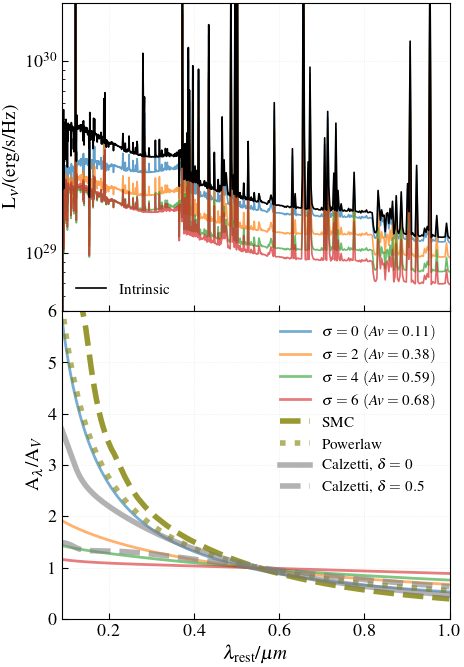

In [6]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(5, 8), sharex=True, sharey=False, facecolor='w', edgecolor='k')
axs = axs.ravel()

req_gal = 0

req_sed = sed_emergent[req_gal]
req_att_curve = att_curve[req_gal]
req_Av = Av[req_gal]

for ii in range(num_gals):
    color = plt.cm.tab10(ii) 
    ok = np.where(grid.lam<=1e4 * Angstrom)[0]
    
    axs[0].plot(grid.lam[ok]/1e4, req_sed[ii].lnu[ok], color=color, alpha=0.7)
    axs[1].plot(grid.lam[ok]/1e4, req_att_curve[ii][ok]/req_Av[ii], label=rF'$\sigma={nsigma[ii]}$ $(Av={np.round(Av[0][ii],2)})$', alpha=0.6, lw=2, color=color)    

axs[0].plot(grid.lam[ok]/1e4, sed_int[req_gal].lnu[ok], color='black', label='Intrinsic')

c = GrainsWD01(model='SMC')
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='SMC', alpha=0.8, ls='dashed', lw=4, color='olive')

c = PowerLaw()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='Powerlaw', alpha=0.6, ls='dotted', lw=4, color='olive')

c = Calzetti2000()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0$', alpha=0.6, ls='solid', lw=4, color='grey')

c = Calzetti2000(slope=0.5)
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0.5$', alpha=0.6, ls='dashed', lw=4, color='grey')

for ax in axs:
    ax.grid(ls='dotted')
    ax.legend(frameon=False, fontsize=11) 
    ax.set_xlim(0.09,1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)
    
axs[0].set_ylabel(r'L$_{\nu}$/(erg/s/Hz)', fontsize=14)
axs[0].set_ylim(5e28, 2e30)
axs[0].set_yscale('log')

axs[1].set_xlabel(r'$\lambda_{\rm rest}$/$\mu m$', fontsize=14)
axs[1].set_ylim(0,6)
axs[1].set_ylabel(r'A$_{\lambda}$/A$_{V}$', fontsize=14)

fig.subplots_adjust(hspace=0,wspace=0)   
plt.savefig('plots/toy_att_curves.png', dpi=300, bbox_inches='tight')   
plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/2007743913.py:32: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=False, fontsize=11, loc=(0.01,1.01), ncols=2, framealpha=0.4)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/2007743913.py:32: SyntaxWarning: invalid escape sequence '\m'
  twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=False, fontsize=11, loc=(0.01,1.01), ncols=2, framealpha=0.4)


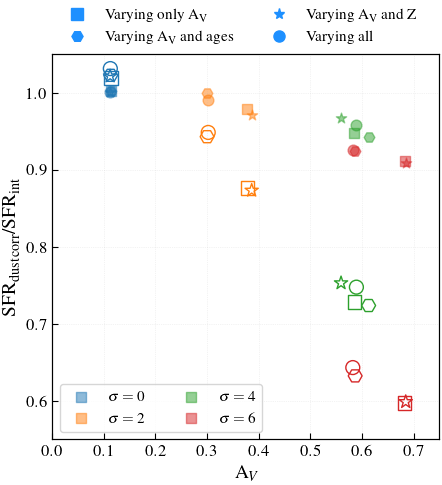

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(5,5), sharex=True, sharey=True, facecolor='w', edgecolor='k')
twinax = ax.twinx()

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

for jj in range(4):    
    for ii in range(num_gals):
        color = plt.cm.tab10(ii)        
      
        # ax.scatter(Av[jj][ii], Halpha_frac_dust[jj][ii], color=color, s=30, marker=markers[jj], alpha=0.8, edgecolors='None')
        
        if jj==0:
            ax.scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.5, label=rF'$\sigma={nsigma[ii]}$')
        else:
            ax.scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.5)
            
        ax.scatter(Av[jj][ii], Halpha_frac_balmercorr[jj][ii], edgecolor=color, facecolor='None', s=100, marker=markers[jj])


ax.set_xlabel(r'A$_{V}$', fontsize=14)
ax.set_ylabel(r'SFR$_{{\rm dust\, corr}}$/SFR$_{\rm int}$', fontsize=14)
ax.set_ylim(0.55, 1.05)
ax.set_xlim(0., 0.75)
ax.grid(ls='dotted')
ax.legend(frameon=True, fontsize=11, ncols=2, loc='lower left') 
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(12)
twinax.set_yticks([])
twinax.set_yticklabels([])

twinax.legend(custom, [r'Varying only A$_{\mathrm{V}}$', 'Varying A$_{\mathrm{V}}$ and ages', 'Varying A$_{\mathrm{V}}$ and Z', 'Varying all'], frameon=False, fontsize=11, loc=(0.01,1.01), ncols=2, framealpha=0.4)
twinax.set_yticks([])
twinax.set_yticklabels([])

plt.savefig('plots/toy_sfr_frac.png', dpi=300, bbox_inches='tight')

plt.show()

/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

5.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 13
    # variables        = 3
    chi-square         = 0.31200574
    reduced chi-square = 0.03120057
    Akaike info crit   = -42.4858799
    Bayesian info crit = -40.7910318
    R-squared          = 0.98780243
[[Variables]]
    logLstar:    1.96401270 +/- 0.22438126 (11.42%) (init = 2)
    logphistar: -4.00856024 +/- 0.65824850 (16.42%) (init = -2.5)
    alpha:      -1.95066061 +/- 0.48266593 (24.74%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8335
    C(logphistar, alpha)    = +0.7286
    C(logLstar, alpha)      = -0.5689


100%|██████████| 4000/4000 [00:15<00:00, 254.24it/s]


5.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 12
    # variables        = 3
    chi-square         = 1.58865360
    reduced chi-square = 0.17651707
    Akaike info crit   = -18.2642374
    Bayesian info crit = -16.8095174
    R-squared          = 0.94033662
[[Variables]]
    logLstar:    1.83265922 +/- 0.19515162 (10.65%) (init = 2)
    logphistar: -4.32400982 +/- 0.56163546 (12.99%) (init = -2.5)
    alpha:      -2.22996887 +/- 0.46987156 (21.07%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7913
    C(logphistar, alpha)    = +0.6349
    C(logLstar, alpha)      = -0.4297


100%|██████████| 4000/4000 [00:15<00:00, 253.47it/s]


5.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 13
    # variables        = 3
    chi-square         = 0.66888531
    reduced chi-square = 0.06688853
    Akaike info crit   = -32.5721964
    Bayesian info crit = -30.8773483
    R-squared          = 0.97502491
[[Variables]]
    logLstar:    1.97454814 +/- 0.21041648 (10.66%) (init = 2)
    logphistar: -4.14398636 +/- 0.61355440 (14.81%) (init = -2.5)
    alpha:      -2.00773635 +/- 0.45976547 (22.90%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8146
    C(logphistar, alpha)    = +0.7118
    C(logLstar, alpha)      = -0.5320


100%|██████████| 4000/4000 [00:15<00:00, 252.98it/s]


5.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 13
    # variables        = 3
    chi-square         = 1.46326432
    reduced chi-square = 0.14632643
    Akaike info crit   = -22.3956345
    Bayesian info crit = -20.7007865
    R-squared          = 0.95934846
[[Variables]]
    logLstar:    1.93023322 +/- 0.16616860 (8.61%) (init = 2)
    logphistar: -4.32454293 +/- 0.53689700 (12.42%) (init = -2.5)
    alpha:      -2.22925411 +/- 0.43455430 (19.49%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8025
    C(logphistar, alpha)    = +0.6609
    C(logLstar, alpha)      = -0.5090


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

6.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 13
    # variables        = 3
    chi-square         = 1.69217319
    reduced chi-square = 0.16921732
    Akaike info crit   = -20.5061647
    Bayesian info crit = -18.8113166
    R-squared          = 0.94151179
[[Variables]]
    logLstar:    1.93253923 +/- 0.18934318 (9.80%) (init = 2)
    logphistar: -4.23116625 +/- 0.56801768 (13.42%) (init = -2.5)
    alpha:      -1.96973430 +/- 0.45344747 (23.02%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8009
    C(logphistar, alpha)    = +0.6962
    C(logLstar, alpha)      = -0.5416


100%|██████████| 4000/4000 [00:15<00:00, 261.52it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:121: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


6.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 10
    # variables        = 3
    chi-square         = 0.31192852
    reduced chi-square = 0.04456122
    Akaike info crit   = -28.6756632
    Bayesian info crit = -27.7679079
    R-squared          = 0.97824644
[[Variables]]
    logLstar:    1.51222584 +/- 0.29191971 (19.30%) (init = 2)
    logphistar: -3.90289054 +/- 0.76090029 (19.50%) (init = -2.5)
    alpha:      -2.05340515 +/- 0.65732267 (32.01%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8218
    C(logphistar, alpha)    = +0.6405
    C(logLstar, alpha)      = -0.4583


100%|██████████| 4000/4000 [00:15<00:00, 256.83it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:153: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


6.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 12
    # variables        = 3
    chi-square         = 0.53587205
    reduced chi-square = 0.05954134
    Akaike info crit   = -31.3051980
    Bayesian info crit = -29.8504781
    R-squared          = 0.97178305
[[Variables]]
    logLstar:    1.84524288 +/- 0.24347785 (13.19%) (init = 2)
    logphistar: -4.13500359 +/- 0.63078423 (15.25%) (init = -2.5)
    alpha:      -1.91955080 +/- 0.50329329 (26.22%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8006
    C(logphistar, alpha)    = +0.6834
    C(logLstar, alpha)      = -0.4852


100%|██████████| 4000/4000 [00:15<00:00, 257.75it/s]


6.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 11
    # variables        = 3
    chi-square         = 0.40299987
    reduced chi-square = 0.05037498
    Akaike info crit   = -30.3738575
    Bayesian info crit = -29.1801716
    R-squared          = 0.97752529
[[Variables]]
    logLstar:    1.62466357 +/- 0.26495454 (16.31%) (init = 2)
    logphistar: -3.88039048 +/- 0.72308635 (18.63%) (init = -2.5)
    alpha:      -1.96712790 +/- 0.60602619 (30.81%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8339
    C(logphistar, alpha)    = +0.6778
    C(logLstar, alpha)      = -0.5294


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

7.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 12
    # variables        = 3
    chi-square         = 0.24707464
    reduced chi-square = 0.02745274
    Akaike info crit   = -40.5956573
    Bayesian info crit = -39.1409373
    R-squared          = 0.98867733
[[Variables]]
    logLstar:    1.77136544 +/- 0.20125214 (11.36%) (init = 2)
    logphistar: -4.22996540 +/- 0.56917738 (13.46%) (init = -2.5)
    alpha:      -1.93767184 +/- 0.50691638 (26.16%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7932
    C(logphistar, alpha)    = +0.6635
    C(logLstar, alpha)      = -0.5133


100%|██████████| 4000/4000 [00:15<00:00, 261.94it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:121: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


7.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 10
    # variables        = 3
    chi-square         = 0.13389994
    reduced chi-square = 0.01912856
    Akaike info crit   = -37.1324756
    Bayesian info crit = -36.2247203
    R-squared          = 0.99247312
[[Variables]]
    logLstar:    1.39277471 +/- 0.24304634 (17.45%) (init = 2)
    logphistar: -3.93107388 +/- 0.70017558 (17.81%) (init = -2.5)
    alpha:      -2.08200932 +/- 0.69672443 (33.46%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8346
    C(logphistar, alpha)    = +0.6219
    C(logLstar, alpha)      = -0.5364


100%|██████████| 4000/4000 [00:15<00:00, 255.82it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:153: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


7.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 11
    # variables        = 3
    chi-square         = 0.45522333
    reduced chi-square = 0.05690292
    Akaike info crit   = -29.0334866
    Bayesian info crit = -27.8398008
    R-squared          = 0.96273955
[[Variables]]
    logLstar:    1.79319862 +/- 0.27972793 (15.60%) (init = 2)
    logphistar: -4.28498073 +/- 0.58242056 (13.59%) (init = -2.5)
    alpha:      -1.87866672 +/- 0.49895912 (26.56%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7287
    C(logphistar, alpha)    = +0.6000
    C(logLstar, alpha)      = -0.2798


100%|██████████| 4000/4000 [00:15<00:00, 260.86it/s]


7.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 11
    # variables        = 3
    chi-square         = 0.77459222
    reduced chi-square = 0.09682403
    Akaike info crit   = -23.1864522
    Bayesian info crit = -21.9927663
    R-squared          = 0.97294044
[[Variables]]
    logLstar:    1.42292826 +/- 0.20078360 (14.11%) (init = 2)
    logphistar: -3.78510514 +/- 0.67162724 (17.74%) (init = -2.5)
    alpha:      -1.95252391 +/- 0.70526021 (36.12%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.8616
    C(logLstar, alpha)      = -0.6912
    C(logphistar, alpha)    = +0.6868


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

8.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 11
    # variables        = 3
    chi-square         = 0.57759515
    reduced chi-square = 0.07219939
    Akaike info crit   = -26.4145510
    Bayesian info crit = -25.2208652
    R-squared          = 0.96055515
[[Variables]]
    logLstar:    1.68081433 +/- 0.22634145 (13.47%) (init = 2)
    logphistar: -4.33916949 +/- 0.53534791 (12.34%) (init = -2.5)
    alpha:      -1.88470221 +/- 0.51527114 (27.34%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7402
    C(logphistar, alpha)    = +0.5839
    C(logLstar, alpha)      = -0.3548


100%|██████████| 4000/4000 [00:15<00:00, 263.85it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:121: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


8.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 10
    # variables        = 3
    chi-square         = 0.27523020
    reduced chi-square = 0.03931860
    Akaike info crit   = -29.9273254
    Bayesian info crit = -29.0195701
    R-squared          = 0.98276469
[[Variables]]
    logLstar:    1.42738823 +/- 0.21941552 (15.37%) (init = 2)
    logphistar: -4.19295637 +/- 0.60553640 (14.44%) (init = -2.5)
    alpha:      -2.04618071 +/- 0.63277930 (30.92%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7911
    C(logphistar, alpha)    = +0.5752
    C(logLstar, alpha)      = -0.4472


100%|██████████| 4000/4000 [00:15<00:00, 260.93it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:153: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


8.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 11
    # variables        = 3
    chi-square         = 0.90671691
    reduced chi-square = 0.11333961
    Akaike info crit   = -21.4540229
    Bayesian info crit = -20.2603371
    R-squared          = 0.93927431
[[Variables]]
    logLstar:    1.68716836 +/- 0.21682966 (12.85%) (init = 2)
    logphistar: -4.40075943 +/- 0.50089888 (11.38%) (init = -2.5)
    alpha:      -1.90229585 +/- 0.49975313 (26.27%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7188
    C(logphistar, alpha)    = +0.5605
    C(logLstar, alpha)      = -0.3103


100%|██████████| 4000/4000 [00:15<00:00, 260.25it/s]


8.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 11
    # variables        = 3
    chi-square         = 0.52888167
    reduced chi-square = 0.06611021
    Akaike info crit   = -27.3837441
    Bayesian info crit = -26.1900582
    R-squared          = 0.97055535
[[Variables]]
    logLstar:    1.62131981 +/- 0.20034353 (12.36%) (init = 2)
    logphistar: -4.34558256 +/- 0.52378584 (12.05%) (init = -2.5)
    alpha:      -1.98818927 +/- 0.53330936 (26.82%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7554
    C(logphistar, alpha)    = +0.5810
    C(logLstar, alpha)      = -0.4109


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

9.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 11
    # variables        = 3
    chi-square         = 0.89757692
    reduced chi-square = 0.11219712
    Akaike info crit   = -21.5654690
    Bayesian info crit = -20.3717832
    R-squared          = 0.95005758
[[Variables]]
    logLstar:    1.59875624 +/- 0.17849898 (11.16%) (init = 2)
    logphistar: -4.47342604 +/- 0.45520543 (10.18%) (init = -2.5)
    alpha:      -1.93846499 +/- 0.52032625 (26.84%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7177
    C(logphistar, alpha)    = +0.5351
    C(logLstar, alpha)      = -0.3715


100%|██████████| 4000/4000 [00:15<00:00, 261.88it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:121: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


9.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 10
    # variables        = 3
    chi-square         = 0.76683022
    reduced chi-square = 0.10954717
    Akaike info crit   = -19.6807495
    Bayesian info crit = -18.7729942
    R-squared          = 0.96180998
[[Variables]]
    logLstar:    1.35382653 +/- 0.18210049 (13.45%) (init = 2)
    logphistar: -4.33148499 +/- 0.52954763 (12.23%) (init = -2.5)
    alpha:      -2.11862609 +/- 0.64055870 (30.23%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7801
    C(logphistar, alpha)    = +0.5219
    C(logLstar, alpha)      = -0.4922


100%|██████████| 4000/4000 [00:15<00:00, 259.49it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:153: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


9.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 11
    # variables        = 3
    chi-square         = 0.94596282
    reduced chi-square = 0.11824535
    Akaike info crit   = -20.9879202
    Bayesian info crit = -19.7942343
    R-squared          = 0.94834096
[[Variables]]
    logLstar:    1.59435469 +/- 0.17269893 (10.83%) (init = 2)
    logphistar: -4.50271956 +/- 0.43687223 (9.70%) (init = -2.5)
    alpha:      -1.96060124 +/- 0.51117822 (26.07%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7072
    C(logphistar, alpha)    = +0.5282
    C(logLstar, alpha)      = -0.3637


100%|██████████| 4000/4000 [00:15<00:00, 263.87it/s]


9.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 10
    # variables        = 3
    chi-square         = 0.66188150
    reduced chi-square = 0.09455450
    Akaike info crit   = -21.1525384
    Bayesian info crit = -20.2447831
    R-squared          = 0.95033884
[[Variables]]
    logLstar:    1.48715206 +/- 0.22320446 (15.01%) (init = 2)
    logphistar: -4.35692259 +/- 0.53561699 (12.29%) (init = -2.5)
    alpha:      -1.95110634 +/- 0.59160658 (30.32%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7265
    C(logphistar, alpha)    = +0.5258
    C(logLstar, alpha)      = -0.3102


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/4123165471.py:49: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
/var/folders/j_/zbbc0z3n0f1c3fncxtfw

10.0 int [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 10
    # variables        = 3
    chi-square         = 1.58205475
    reduced chi-square = 0.22600782
    Akaike info crit   = -12.4386061
    Bayesian info crit = -11.5308509
    R-squared          = 0.90645498
[[Variables]]
    logLstar:    1.52742033 +/- 0.16432968 (10.76%) (init = 2)
    logphistar: -4.53833929 +/- 0.40345759 (8.89%) (init = -2.5)
    alpha:      -1.85934132 +/- 0.53304795 (28.67%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6388
    C(logphistar, alpha)    = +0.4859
    C(logLstar, alpha)      = -0.2997


100%|██████████| 4000/4000 [00:14<00:00, 267.75it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:121: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


10.0 obs [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 9
    # variables        = 3
    chi-square         = 1.03270890
    reduced chi-square = 0.17211815
    Akaike info crit   = -13.4853531
    Bayesian info crit = -12.8936793
    R-squared          = 0.94120108
[[Variables]]
    logLstar:    1.14132147 +/- 0.19369007 (16.97%) (init = 2)
    logphistar: -4.21007795 +/- 0.57458895 (13.65%) (init = -2.5)
    alpha:      -2.10083642 +/- 0.75247932 (35.82%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7872
    C(logLstar, alpha)      = -0.5201
    C(logphistar, alpha)    = +0.4648


100%|██████████| 4000/4000 [00:15<00:00, 262.31it/s]
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_18571/115955477.py:153: RuntimeWarning: divide by zero encountered in log10
  ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)


10.0 Av [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 10
    # variables        = 3
    chi-square         = 1.49919351
    reduced chi-square = 0.21417050
    Akaike info crit   = -12.9765779
    Bayesian info crit = -12.0688226
    R-squared          = 0.91346904
[[Variables]]
    logLstar:    1.51540489 +/- 0.15639620 (10.32%) (init = 2)
    logphistar: -4.56365220 +/- 0.38599090 (8.46%) (init = -2.5)
    alpha:      -1.88037015 +/- 0.53560828 (28.48%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.6241
    C(logphistar, alpha)    = +0.4613
    C(logLstar, alpha)      = -0.3006


100%|██████████| 4000/4000 [00:14<00:00, 270.31it/s]


10.0 balmer [[Model]]
    Model(schechter_fn)
[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 800000
    # data points      = 10
    # variables        = 3
    chi-square         = 1.26783934
    reduced chi-square = 0.18111991
    Akaike info crit   = -14.6527095
    Bayesian info crit = -13.7449542
    R-squared          = 0.93606326
[[Variables]]
    logLstar:    1.32624425 +/- 0.17082558 (12.88%) (init = 2)
    logphistar: -4.37697649 +/- 0.49395834 (11.29%) (init = -2.5)
    alpha:      -2.01788016 +/- 0.65058776 (32.24%) (init = -1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(logLstar, logphistar) = -0.7610
    C(logphistar, alpha)    = +0.5060
    C(logLstar, alpha)      = -0.5017


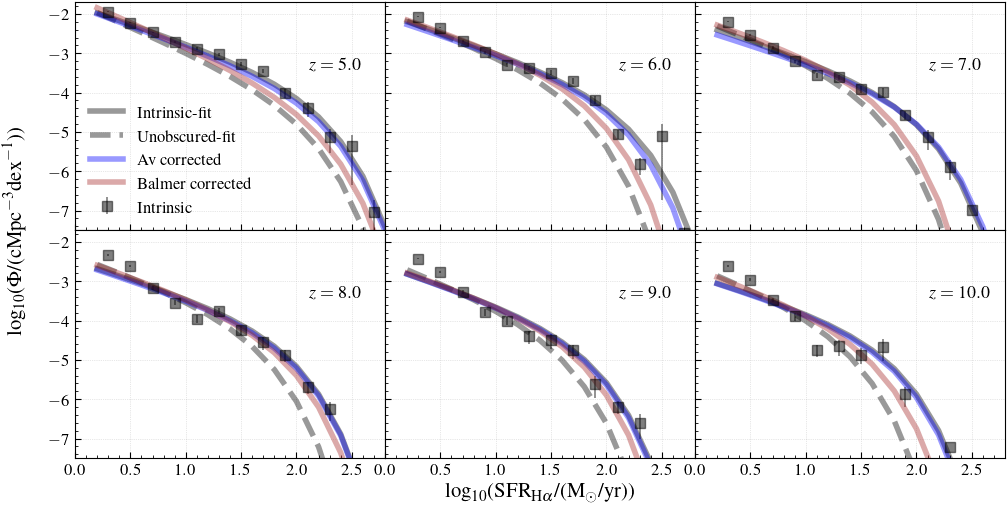

In [8]:
h = 0.6777
vol = (4/3)*np.pi*(14/h)**3
quantiles = [0.16,0.50,0.84]
df = pd.read_csv('./data/weights_grid.txt')
weights = np.array(df['weights'])

sfrbins = np.arange(0.2, 2.91, 0.2)
bincen = (sfrbins[1:]+sfrbins[:-1])/2.
binwidth = sfrbins[1:] - sfrbins[:-1]

sfrbinslow = np.arange(0.5, 2.91, 0.2)
sfrbinshigh = np.arange(1.5, 2.91, 0.2)

tags = ['010_z005p000', '009_z006p000', '008_z007p000', '007_z008p000', '006_z009p000', '005_z010p000']

obsc_frac = np.zeros((2, len(tags)))
obsc_frac_err = np.zeros((2, len(tags)))

sfrd_frac_Av = np.zeros((2, len(tags)))
sfrd_frac_Av_err = np.zeros((2, len(tags)))

sfrd_frac_balmer = np.zeros((2, len(tags)))
sfrd_frac_balmer_err = np.zeros((2, len(tags)))

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(12, 6), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()

for ii, tag in enumerate(tags):
       
    z = float(tag[5:].replace('p','.'))

    func    = partial(get_data, tag=tag)
    pool    = MultiPool(processes=4)
    dat     = np.array(list(pool.map(func, np.arange(0,40))), dtype='object')
    pool.close()

    Mstar = np.log10(np.concatenate(dat[:,0]))
    MFUVatt = np.concatenate(dat[:,1])
    Halpha = np.concatenate(dat[:,2])
    Hbeta = np.concatenate(dat[:,3])
    Halphaint = np.concatenate(dat[:,4])
    Hbetaint = np.concatenate(dat[:,5])
    MassweightedZ = np.concatenate(dat[:,6])
    MFUVint = np.concatenate(dat[:,7])
    Av = np.concatenate(dat[:,8])
    
    Halpha_Av = calc_line_corr_from_Av(Halpha * erg/s, lam_Ha, Av, slope=0).to_value()
    Halpha_balmer =  calc_line_corr(Halpha * erg/s, lam_Ha, Halpha/Hbeta, slope=0).to_value() 
    
    sfr_int = np.log10(Ha_to_SFR(Halphaint))
    sfr_dust = np.log10(Ha_to_SFR(Halpha))
    sfr_Av = np.log10(Ha_to_SFR(Halpha_Av))
    sfr_balmer = np.log10(Ha_to_SFR(Halpha_balmer))
    
    tot_gals = len(Mstar)
    
    n = np.array([])
    for jj in range(40):
        n = np.append(n, len(dat[jj][0]))

    #Make the SFR distribution function, integrate the different ratio to get the recovered fraction
   
    hist, M, err = get_flares_LF(sfr_int, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    axs[ii].errorbar(bincen, np.log10(phi), yerr=[np.log10(phi)-np.log10(phi-phierr), np.log10(phi+phierr)-np.log10(phi)], ls='None', marker='s', color='black', label='Intrinsic', alpha=0.5, markersize=7)
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='black')
    
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi[ok]), bincen[ok])
    print (z, 'int', result.fit_report())
    fit = np.array([*result.best_values.values()])
    fiterr = np.array(result.flatchain.std())
    f = unc_schechter_fn(sfrbins, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    axs[ii].plot(sfrbins, unumpy.nominal_values(f), lw=4, alpha=0.4, ls='solid', label='Intrinsic-fit', color='black')
    
    f = unc_schechter_log(sfrbinslow, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tot = integrate.simpson(f, sfrbinslow) 
    
    f = unc_schechter_log(sfrbinshigh, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tothigh = integrate.simpson(f, sfrbinshigh)
    
    
    hist, M, err = get_flares_LF(sfr_dust, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    # axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='dashed', label='Observed', color='black')
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi[ok]), bincen[ok])
    print (z, 'obs', result.fit_report())
    fit = np.array([*result.best_values.values()])
    fiterr = np.array(result.flatchain.std())
    f = unc_schechter_fn(sfrbins, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))   
    axs[ii].plot(sfrbins, unumpy.nominal_values(f), lw=4, alpha=0.4, ls='dashed', label='Unobscured-fit', color='black') 
    
    f = unc_schechter_log(sfrbinslow, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))   
    tmp = integrate.simpson(f, sfrbinslow) / tot    
    obsc_frac[0][ii] = unumpy.nominal_values(tmp)
    obsc_frac_err[0][ii] = unumpy.std_devs(tmp)
    f = unc_schechter_log(sfrbinshigh, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tmp = integrate.simpson(f, sfrbinshigh) / tothigh
    obsc_frac[1][ii] = unumpy.nominal_values(tmp)
    obsc_frac_err[1][ii] = unumpy.std_devs(tmp)
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='black')
    # tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen) / tot
    # obsc_frac[0][ii] = unumpy.nominal_values(tmp)
    # obsc_frac_err[0][ii] = unumpy.std_devs(tmp)
        
    # hist, M, err = get_flares_LF(sfr_dust, weights, sfrbinshigh, n)
    # phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
    # tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh) / tothigh
    # obsc_frac[1][ii] = unumpy.nominal_values(tmp)
    # obsc_frac_err[1][ii] = unumpy.std_devs(tmp)
    
    
    hist, M, err = get_flares_LF(sfr_Av, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    # axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='solid', label='Av corrected', color='blue')
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='blue')
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi[ok]), bincen[ok])
    print (z, 'Av', result.fit_report())
    fit = np.array([*result.best_values.values()])
    fiterr = np.array(result.flatchain.std())
    f = unc_schechter_fn(sfrbins, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))  
    axs[ii].plot(sfrbins, unumpy.nominal_values(f), lw=4, alpha=0.4, ls='solid', label='Av corrected', color='blue')  
    
    f = unc_schechter_log(sfrbinslow, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))  
    tmp = integrate.simpson(f, sfrbinslow) / tot
    sfrd_frac_Av[0][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_Av_err[0][ii] = unumpy.std_devs(tmp)
    f = unc_schechter_log(sfrbinshigh, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tmp = integrate.simpson(f, sfrbinshigh) / tothigh
    sfrd_frac_Av[1][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_Av_err[1][ii] = unumpy.std_devs(tmp)
#     tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincen) / tot
#     sfrd_frac_Av[0][ii] = unumpy.nominal_values(tmp)
#     sfrd_frac_Av_err[0][ii] = unumpy.std_devs(tmp)
        
#     hist, M, err = get_flares_LF(sfr_Av, weights, sfrbinshigh, n)
#     phi, phierr = M/(binwidthhigh*vol), err/(binwidthhigh*vol)
#     tmp = integrate.simpson(unumpy.uarray(phi, phierr), 10**bincenhigh) / tothigh
#     sfrd_frac_Av[1][ii] = unumpy.nominal_values(tmp)
#     sfrd_frac_Av_err[1][ii] = unumpy.std_devs(tmp)
    
    
    hist, M, err = get_flares_LF(sfr_balmer, weights, sfrbins, n)
    ok = np.where(hist>=5)[0]
    phi, phierr = M/(binwidth*vol), err/(binwidth*vol)
    # axs[ii].plot(bincen, np.log10(phi), lw=4, alpha=0.4, ls='solid', label='Balmer corrected', color='brown')
    # axs[ii].fill_between(bincen[ok], np.log10(phi[ok]-phierr[ok]), np.log10(phi[ok]+phierr[ok]), alpha=0.25, color='brown')
    ok = np.isfinite(np.log10(phi)) * np.isfinite(bincen)
    result = fit_schechter(np.log10(phi[ok]), bincen[ok])
    print (z, 'balmer', result.fit_report())
    fit = np.array([*result.best_values.values()])
    fiterr = np.array(result.flatchain.std())
    f = unc_schechter_fn(sfrbins, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))    
    axs[ii].plot(sfrbins, unumpy.nominal_values(f), lw=4, alpha=0.4, ls='solid', label='Balmer corrected', color='brown')  
    
    f = unc_schechter_log(sfrbinslow, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))    
    tmp = integrate.simpson(f, sfrbinslow) / tot
    sfrd_frac_balmer[0][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_balmer_err[0][ii] = unumpy.std_devs(tmp)
    f = unc_schechter_log(sfrbinshigh, unumpy.uarray(fit[0], fiterr[0]), unumpy.uarray(fit[1], fiterr[1]), unumpy.uarray(fit[2], fiterr[2]))
    tmp = integrate.simpson(f, sfrbinshigh) / tothigh
    sfrd_frac_balmer[1][ii] = unumpy.nominal_values(tmp)
    sfrd_frac_balmer_err[1][ii] = unumpy.std_devs(tmp)
   
    axs[ii].text(2.1, -3.4, r'$z = {}$'.format(z), fontsize = 13)
    
for ax in axs:
    ax.grid(True, alpha=0.6, ls='dotted')
    ax.set_xlim(0., 2.8)
    ax.set_ylim(-7.5, -1.7)
    ax.minorticks_on()
    ax.tick_params(axis='x', which='minor', direction='in')
    ax.tick_params(axis='y', which='minor', direction='in')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

axs[0].legend(frameon=False, fontsize=12)
axs[4].set_xlabel(r'log$_{10}$($\mathrm{SFR}_{\rm H\alpha}$/(M$_{\odot}$/yr))', fontsize=15)

fig.subplots_adjust(bottom=0.12, wspace=0, hspace=0)

fig.text(0.065, 0.5, r'log$_{10}$($\Phi$/($\mathrm{cMpc}^{-3}\mathrm{dex}^{-1}$))', va='center', rotation='vertical', fontsize=15)

plt.savefig('plots/sfr_function.png', dpi=300, bbox_inches='tight')

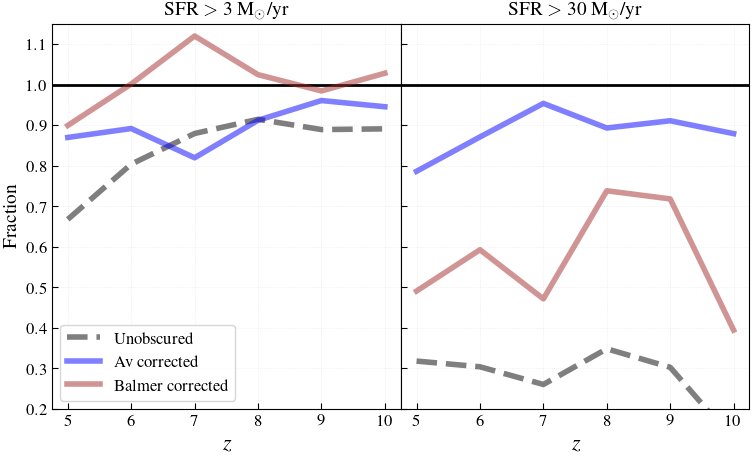

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(9, 5), sharex=True, sharey=True, facecolor='w', edgecolor='k')
axs = axs.ravel()

zs = np.arange(5,11,1)

axs[0].plot(zs, obsc_frac[0], color='black', label='Unobscured', ls='dashed', lw=4, alpha=0.5)
# axs[0].fill_between(zs, obsc_frac[0] - obsc_frac_err[0], obsc_frac[0] + obsc_frac_err[0], alpha=0.2, color='black')

axs[0].plot(zs, sfrd_frac_Av[0], color='blue', label='Av corrected', lw=4, alpha=0.5)
# axs[0].fill_between(zs, sfrd_frac_Av[0] - sfrd_frac_Av_err[0], sfrd_frac_Av[0] + sfrd_frac_Av_err[0], alpha=0.4, color='blue')

axs[0].plot(zs, sfrd_frac_balmer[0], color='brown', label='Balmer corrected', lw=4, alpha=0.5, zorder=10)
# axs[0].fill_between(zs, sfrd_frac_balmer[0] - sfrd_frac_balmer_err[0], sfrd_frac_balmer[0] + sfrd_frac_balmer_err[0], alpha=0.4, color='brown')

axs[1].plot(zs, obsc_frac[1], color='black', ls='dashed', lw=4, alpha=0.5)
# axs[1].fill_between(zs, obsc_frac[1] - obsc_frac_err[1], obsc_frac[1] + obsc_frac_err[1], alpha=0.2, color='black')

axs[1].plot(zs, sfrd_frac_Av[1], color='blue', lw=4, alpha=0.5)
# axs[1].fill_between(zs, sfrd_frac_Av[1] - sfrd_frac_Av_err[1], sfrd_frac_Av[1] + sfrd_frac_Av_err[1], alpha=0.4, color='blue')

axs[1].plot(zs, sfrd_frac_balmer[1], color='brown', lw=4, alpha=0.5)
# axs[1].fill_between(zs, sfrd_frac_balmer[1] - sfrd_frac_balmer_err[1], sfrd_frac_balmer[1] + sfrd_frac_balmer_err[1], alpha=0.4, color='orange')

axs[0].legend(fontsize=12, frameon=True)

for ax in axs:
    ax.axhline(y=1.0, color='black', lw=2)
    ax.grid(ls='dotted')
    ax.set_ylim(0.2, 1.15)
    ax.set_yticks(np.arange(0.2, 1.16, 0.1))
    ax.set_xlabel(r'$z$', fontsize=16)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(12)

axs[0].set_ylabel('Fraction', fontsize=14)
axs[0].set_title(r'SFR $>$ 3 M$_{\odot}$/yr', fontsize=14)   
axs[1].set_title(r'SFR $>$ 30 M$_{\odot}$/yr', fontsize=14)   

fig.subplots_adjust(hspace=0,wspace=0)
plt.savefig('plots/sfrd_frac.png', dpi=300, bbox_inches='tight')
